In [62]:
import numpy as np
import os
import time

from lmfit.models import GaussianModel, Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture, metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg

import skimage
from skimage import io, transform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage import color

from PIL import Image, ImageDraw, ImageFilter, ImageOps
import copy
import cv2
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import logging
import glob
from radio_beam.commonbeam import getMinVolEllipse


from src.utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology,grainGenerate
from src.cfg import CfgAnglesNames, CfgBeamsNames, CfgDataset


In [5]:
folder_path='../data/dataset_cleaned'
new_folder_path='../data/dataset_4x'

folders = os.listdir(folder_path)

# создает папку для обработанных фотографий
if not os.path.exists(new_folder_path):
    os.mkdir(new_folder_path)

# создает папку для каждого класса фотографий
for folder in folders:
    if not os.path.exists(new_folder_path + '/' + folder):
        os.mkdir(new_folder_path + '/' + folder)


for i, folder in enumerate(folders):
    images_names = os.listdir(folder_path + '/' + folder)
    for i, name in enumerate(images_names):
        if 'hdr' not in name:
            image = io.imread(folder_path + '/' + folder + '/' + name)
            image_combined = grainPreprocess.combine(image, h=144)
            height,width=image_combined.shape
            img1=image_combined[:height//2,:width//2]
            img2=image_combined[:height//2,width//2:]
            img3=image_combined[height//2:,:width//2]
            img4=image_combined[height//2:,width//2:]
            # image_resized = transform.resize(image_combined, (512,512),preserve_range=True).astype(np.uint8)

            # io.imsave(new_folder_path + '/' + folder + '/' + name , image_resized)
            io.imsave(new_folder_path + '/' + folder + '/' + name[:-5]+'_1'+ name[-5:] , img1)
            io.imsave(new_folder_path + '/' + folder + '/' + name[:-5]+'_2'+ name[-5:] , img2)
            io.imsave(new_folder_path + '/' + folder + '/' + name[:-5]+'_3'+ name[-5:] , img3)
            io.imsave(new_folder_path + '/' + folder + '/' + name[:-5]+'_4'+ name[-5:] , img4)

In [ ]:
def img_load_preprocess(path, img_names, h=150, k=1):
    imgs = []
    for i, class_img_names in enumerate(img_names):
        imgs.append([])
        for name in class_img_names:
            img = io.imread(path + '/' + name)
            img = grainPreprocess.image_preprocess(img, h, k)
            imgs[i].append(img)
    return imgs

In [ ]:
path = 'data/images'
all_images = np.load('data/saved np/all_images.npy', allow_pickle=True)

grain_names = np.array(
    [['Ultra_Co8.jpg'], ['Ultra_Co11.jpg'], ['Ultra_Co6_2.jpg'], ['Ultra_Co15.jpg'], ['Ultra_Co25.jpg']])
types = ['средние зерна', 'мелкие зерна', 'мелкие зерна', 'крупные зерна', 'средне-мелкие зерна']
grain_images = img_load_preprocess(path, grain_names)

### Считаем все изображения, предобработаем их и сохраним

In [4]:
all_images = grainPreprocess.read_preprocess_data(images_dir='../data/dataset_4x/', save_name='images_4x.npy',
                                                  max_images_num_per_class=90,
                                                  preprocess=True, save=True, crop_bottom=False, resize=False,
                                                  resize_shape=None)

Progress: |██████████████████████████████████████████████████| 100.0% Complete ETA:0.0 s


### Сгенерируем распределения углов, аппроксимируем их бимодальным гауссом и сохраним

In [ ]:
from src.utils import grainGenerate,GrainLogs,grainMark,grainStats,grainApprox
import numpy as np

In [9]:
# images = np.load('data/saved np/all_images.npy', allow_pickle=True)
images = np.load('../data/saved np/images_4x.npy')

# path = 'data/saved np'
path = 'data'
name='4x_data_'
grain_names = np.array(
    [['Ultra_Co8.jpg'], ['Ultra_Co11.jpg'], ['Ultra_Co6_2.jpg'], ['Ultra_Co15.jpg'], ['Ultra_Co25.jpg']])
types = ['средние зерна', 'мелкие зерна', 'мелкие зерна', 'крупные зерна', 'средне-мелкие зерна']

for step in range(1, 6):
    grainGenerate.angles_approx_save(path, images,name, grain_names[:, 0], types, step, save=True)


Progress: |██████████████████████████████| 100.0% Complete ETA:None s
Progress: |██████████████████████████████| 100.0% Complete ETA:None s
Progress: |██████████████████████████████| 100.0% Complete ETA:None s
Progress: |██████████████████████████████| 100.0% Complete ETA:None s
Progress: |██████████████████████████████| 100.0% Complete ETA:None s


In [88]:
def angles_approx(folder,name, step, width, height,y_lim=None,save=False, font_size=20):
    #
    # вывод распределения углов для всех фотографий одного образца
    #

    xy_scatter = np.load(f'{folder}/' + CfgAnglesNames.values+f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_gauss = np.load(f'{folder}/' + CfgAnglesNames.approx+f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_gauss_data = np.load(f'{folder}/' + CfgAnglesNames.approx_data+f'{name}' + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgAnglesNames.legend+f'{name}' + f'{step}.npy', allow_pickle=True)

    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(width, height))

    ax = plt.subplot(gs[0])
    # маркеры для одновременного вывода скаттера для разных классов
    # количество варкеров=количество классов-1
    markers = ['v', 's', 'D', 'd', 'p', '*']
    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax.plot(xy_gauss[i][0], xy_gauss[i][1])
        ax.scatter(xy_scatter[i][0], xy_scatter[i][1], marker=marker)


    ax.legend(texts, fontsize=14, loc=1)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)

    if y_lim:
        plt.ylim(0,y_lim)
    # plt.autoscale(enable=True, axis='y')

    if save:
        plt.savefig(f'распределение углов шаг {step}')


    plt.show()

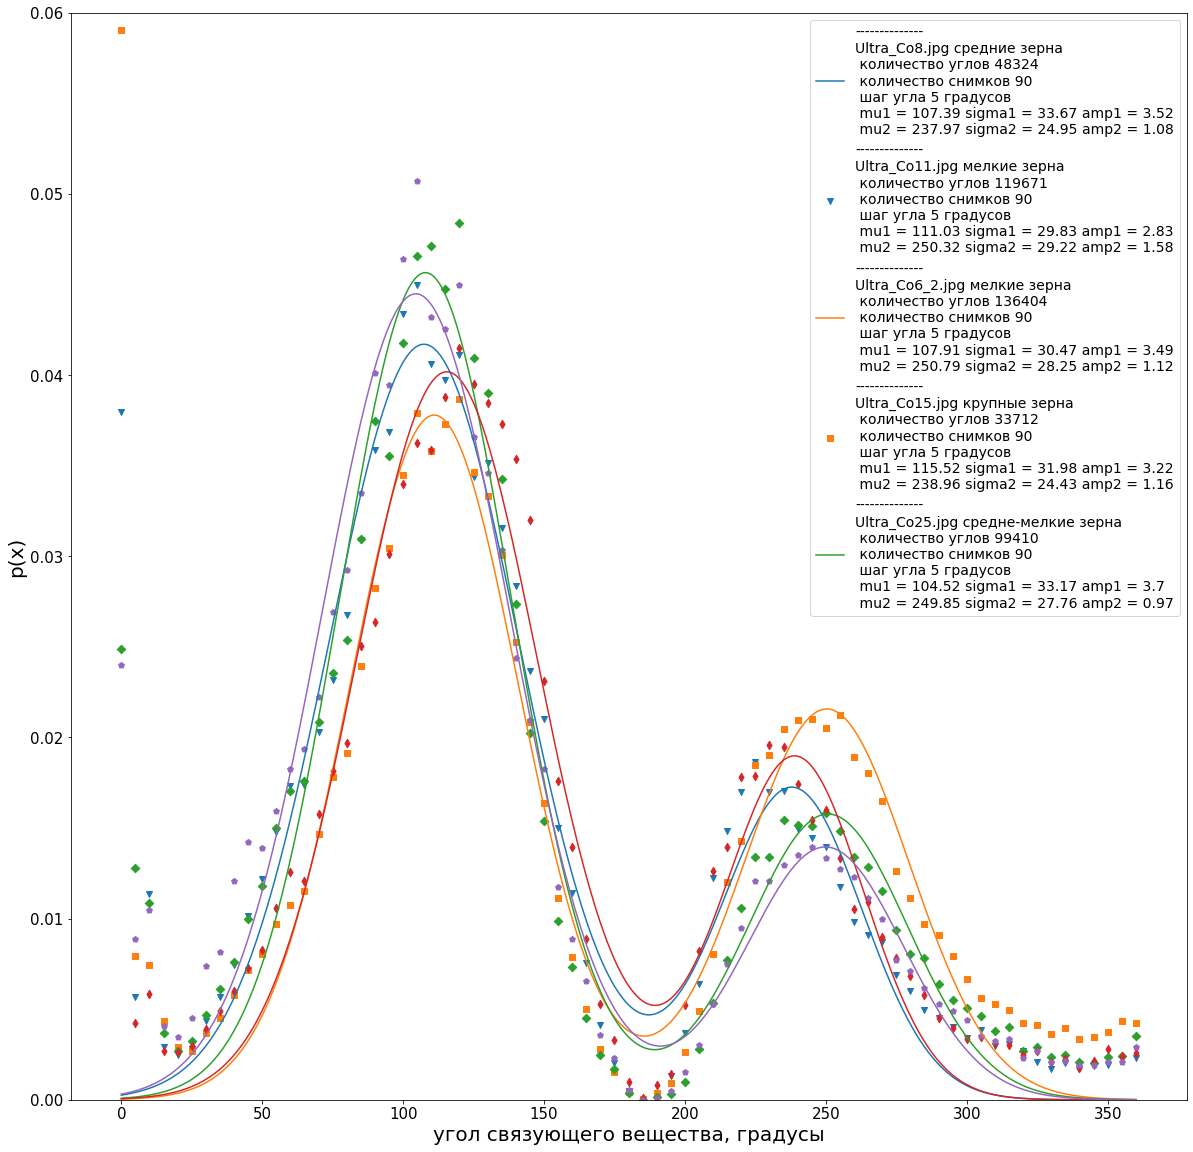

In [107]:
folder = 'data/'
step = 5
width = 20
height = 20
name='4x_data_'
y_lim=0.06
save=False

# генерация распределения, аппроксимирование распределения и сохранение данных
angles_approx(folder,name, step, width, height,y_lim=y_lim,save=save)

In [ ]:
def angles_approx(folder, step, width, height,save=False, font_size=20):
    #
    # вывод распределения углов для всех фотографий одного образца
    #

    xy_scatter = np.load(f'{folder}/' + CfgAnglesNames.values + f'{step}.npy', allow_pickle=True)
    xy_gauss = np.load(f'{folder}/' + CfgAnglesNames.approx + f'{step}.npy', allow_pickle=True)
    xy_gauss_data = np.load(f'{folder}/' + CfgAnglesNames.approx_data + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgAnglesNames.legend + f'{step}.npy', allow_pickle=True)

    synth_angles=np.load(f'{folder}/wc-co.npy')
    synth_angles=np.concatenate([synth_angles,np.zeros((180))])

    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(width, height))

    ax = plt.subplot(gs[0])
    # маркеры для одновременного вывода скаттера для разных классов
    # количество варкеров=количество классов-1
    markers = ['v', 's', 'D', 'd', 'p', '*']
    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax.plot(xy_gauss[i][0], xy_gauss[i][1])
        ax.scatter(xy_scatter[i][0], xy_scatter[i][1], marker=marker)

    ax.plot(synth_angles[::-1])

    texts=list(texts)
    texts.append('синтетические углы')
    ax.legend(texts, fontsize=14, loc=2)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)
    if save:
        plt.savefig(f'наложение {step}')


    plt.show()

In [ ]:
folder = 'data/saved np/'
step = 5
width = 20
height = 20

# генерация распределения, аппроксимирование распределения и сохранение данных
angles_approx(folder, step, width, height,save=True)

In [ ]:
def angles_approx_modes(folder, step, start1, stop1, start2, stop2, width, height, font_size=25):
    #
    # аппроксимация каждой моды
    #
    xy_scatter_o = np.load(f'{folder}/xy_scatter_step_{step}.npy', allow_pickle=True)
    xy_gauss_o = np.load(f'{folder}/xy_gauss_step_{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/texts_step_{step}.npy', allow_pickle=True)

    xy_scatter1 = []
    xy_scatter2 = []

    for j, sc in enumerate(xy_scatter_o):
        x = sc[0]
        y = sc[1]
        xy_scatter1.append([[], []])
        xy_scatter2.append([[], []])
        for i, xi in enumerate(x):
            if xi <= stop1 and xi >= start1:
                xy_scatter1[j][0].append(x[i])
                xy_scatter1[j][1].append(y[i])

            if xi <= stop2 and xi >= start2:
                xy_scatter2[j][0].append(x[i])
                xy_scatter2[j][1].append(y[i])

    plt.rcParams['font.size'] = '25'
    markers = ['v', 's', 'D', 'd', 'p', '*']
    k = 2
    for i in range(len(xy_scatter_o)):
        plt.figure(figsize=(width, height))
        marker = markers[i]

        #    plt.scatter(xy_scatter_o[i][0],xy_scatter_o[i][1])

        x1 = np.array(xy_scatter1[i][0])
        y1 = xy_scatter1[i][1]

        x2 = np.array(xy_scatter2[i][0])
        y2 = xy_scatter2[i][1]

        mu1, sigma1, amp1 = grainApprox.gaussian_fit(x1, y1, mu=120)
        mu2, sigma2, amp2 = grainApprox.gaussian_fit(x2, y2, mu=225)

        x_gauss1 = np.arange(mu1 - 3 * sigma1, mu1 + 3 * sigma1)
        x_gauss2 = np.arange(mu2 - 3 * sigma2, mu2 + 3 * sigma2)

        y_gauss1 = grainStats.gaussian(x_gauss1, mu1, sigma1, amp1)
        y_gauss2 = grainStats.gaussian(x_gauss2, mu2, sigma2, amp2)

        #    plt.plot(x_gauss,y_gauss)
        plt.scatter(x1, y1, marker=marker)
        plt.plot(x_gauss1, y_gauss1)

        plt.scatter(x2, y2, marker=markers[i + 1])
        plt.plot(x_gauss2, y_gauss2)

        #  print('mu1=',mu1,' sigma1=',sigma1,'amp1=',amp1)
        #  print('mu2=',mu2,' sigma2=',sigma2,'amp2=',amp2)
        plt.legend(['moda1', 'moda2', 'approx1', texts[i]], fontsize=14, loc=1)
        plt.ylabel('p(x)', fontsize=font_size)
        plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)
        # plt.ylim([0,max(np.log(xy_scatter[i][1][:-1]))])
    # plt.savefig('крупные моды отдельная аппрокс  ' + names[i])

    #  print(texts)

    #  plt.savefig('распределение углов')
    plt.show()

In [ ]:
folder = 'saved np'
width = 12
height = 15

step = 1

start = 340
stop = 360

start1 = 50
stop1 = 180

start2 = 180
stop2 = 300

angles_approx_modes(folder, step, start1, stop1, start2, stop2, width, height)

## Распределение диаметров

In [ ]:
pixel = 49.7 / 1000
step = 5

images = np.load('data/saved np/images_with_filters.npy')

folder = 'data/'
names = np.array(
    [['Ultra_Co8.jpg'], ['Ultra_Co11.jpg'], ['Ultra_Co6_2.jpg'], ['Ultra_Co15.jpg'], ['Ultra_Co25.jpg']])
types = ['средние зерна', 'мелкие зерна', 'мелкие зерна', 'крупные зерна', 'средне-мелкие зерна']

for step in range(5, 6):
    # print('step: ',step)
    grainGenerate.diametr_approx_save(folder, images, names[:, 0], types, step, pixel, save=False)

In [ ]:
def diametr_approx_all(folder, step, N, M):
    #
    # вывод распределения длин а- и б- полуосей для разных образцов
    #

    xy_scatter = np.load(f'{folder}/' + CfgBeamsNames.values + f'{step}.npy', allow_pickle=True)
    xy_linear = np.load(f'{folder}/' + CfgBeamsNames.approx + f'{step}.npy', allow_pickle=True)
    xy_linear_data = np.load(f'{folder}/' + CfgBeamsNames.approx_data + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgBeamsNames.legend + f'{step}.npy', allow_pickle=True)

    plt.rcParams['font.size'] = '20'
    gs = gridspec.GridSpec(2, 1)
    # для статьи 12,18
    plt.figure(figsize=(N, M))

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.set_title('распределение a-полуосей связующего вещества', fontsize=20)
    ax2.set_title('распределение b-полуосей связующего вещества', fontsize=20)

    ax1.set_ylabel('ln(p(x))', fontsize=15)
    ax1.set_xlabel('длина полуоси, мкм', fontsize=15)

    ax2.set_ylabel('ln(p(x))', fontsize=15)
    ax2.set_xlabel('длина полуоси, мкм', fontsize=15)

    #  ax3.grid()
    markers = ['v', 's', 'D', 'd', 'p', '*']
    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax1.plot(xy_linear[i][0][0], xy_linear[i][0][1])
        ax1.scatter(xy_scatter[i][0][0], xy_scatter[i][0][1], marker=marker)

        ax2.plot(xy_linear[i][1][0], xy_linear[i][1][1])
        ax2.scatter(xy_scatter[i][1][0], xy_scatter[i][1][1], marker=marker)

    #  plt.savefig('распределение полуосей')

    ax1.legend(texts[:, 0], fontsize=14, loc=1)
    ax2.legend(texts[:, 1], fontsize=14, loc=1)
    plt.show()


In [ ]:
N = 30
M = 30
# для статье N=12,M=18

step = 5

folder = '../data/saved np'

diametr_approx_all(folder, step, N, M)

### Вывод на снимке ненормалных углов

In [67]:
def draw_edges(image):
    #
    # рисует на изображении линии по точкам контура cnts
    # линии в стиле x^1->x^2,x^2->x^3 и тд
    # на вход подавать обработанное изображение
    #

    # new_image = skimage.color.gray2rgb(image)
    new_image=image[:,:,0]
    # im = Image.fromarray(np.uint8(cm.gist_earth(new_image) * 255))
    im= Image.fromarray(np.uint8(new_image)).convert('RGB')
    # im = Image.fromarray((new_image * 255).astype(np.uint8))
    draw = ImageDraw.Draw(im)
    width = 50

    cnts = grainMark.get_contours(image, tol=4)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 2:
            for i, point in enumerate(cnt[:-1]):

                point1 = cnt[i - 1]
                point2 = cnt[i]
                point3 = cnt[i + 1]
                x1, y1 = point1[1], point1[0]
                x2, y2 = point2[1], point2[0]
                x3, y3 = point3[1], point3[0]
                thr = 5
                if abs(x2 - image.shape[0] - 1) > thr and abs(y2 - image.shape[1] - 1) > thr and x2 > thr and y2 > thr:
                    v1 = np.array((x1 - x2, y1 - y2)).reshape(1, 2)
                    v2 = np.array((x3 - x2, y3 - y2)).reshape(1, 2)

                    dot = np.dot(v1[0], v2[0])
                    dist1 = np.linalg.norm(v1[0])
                    dist2 = np.linalg.norm(v2[0])
                    cos = dot / (dist1 * dist2)

                    v = np.concatenate([v1, v2])
                    det = np.linalg.det(v)

                    angle = 0
                    if abs(cos) < 1:
                        ang = int(np.arccos(cos) * 180 / np.pi)
                        if det < 0:
                            angle = ang
                        else:
                            angle = 360 - ang

                    p2 = point

                    x2, y2 = p2[1], p2[0]

                    color = (150, 150, 150)

                    line_color = (0, 255, 127)
                    if angle <= 25:
                        color = (0, 0, 255)
                        r = 4
                        draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=5)
                        draw.line((point1[0], point1[1], point2[0], point2[1]), fill=line_color, width=4)
                        draw.line((point3[0], point3[1], point2[0], point2[1]), fill=line_color, width=4)


                    elif angle >= 330:
                        color = (255, 0, 0)
                        r = 4
                        draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=5)
                        draw.line((point1[0], point1[1], point2[0], point2[1]), fill=line_color, width=4)
                        draw.line((point3[0], point3[1], point2[0], point2[1]), fill=line_color, width=4)
                        print('cnt index: ', j)
                        print('point2 ', point2)

        else:
            continue

    img = np.array(im)

    return img

In [111]:
# img=io.imread('../data/dataset_4x/Ultra_Co8/Ultra_Co8-001_1.jpeg')
i=19
img = np.load('../data/saved np/images_4x.npy')[0,i]
im=draw_edges(img)
io.imsave(f'малые углы_{i}.png', im)

cnt index:  4
point2  [223 756]
cnt index:  30
point2  [505 733]
cnt index:  36
point2  [ 13 743]
cnt index:  36
point2  [ 39 708]
cnt index:  46
point2  [716 671]
cnt index:  49
point2  [715 673]
cnt index:  49
point2  [727 683]


In [53]:
img.shape

(768, 768, 1)

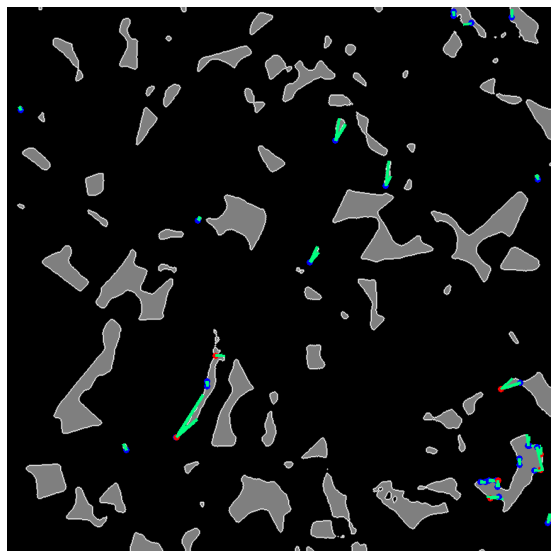

In [69]:
grainShow.img_show(im,10,cmap='gray')

In [20]:
cnts=
img_cnts=grainDraw.draw_edges(img,cnts)

(768, 768, 1)

In [70]:
io.imsave('малые углы.png', im)

In [71]:
images_dir='../data/dataset_4x/'
folders_names = glob.glob(images_dir + '*')
images_paths = [glob.glob(folder_name + '/*') for folder_name in folders_names]
images_paths

[['../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-100_1.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-100_2.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-100_3.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-100_4.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-11_1.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-11_2.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-11_3.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-11_4.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-12_1.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-12_2.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-12_3.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-12_4.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-13_1.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-13_2.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-13_3.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-13_4.jpeg',
  '../data/dataset_4x\\Ultra_Co11\\Ultra_Co11-14_1.jpeg',
  '../data